In [22]:
%matplotlib inline
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import theano

from pymc3.ode import DifferentialEquation
from scipy.integrate import odeint

plt.style.use("seaborn-darkgrid")

Consider the equation of motion for an object falling under gravity,
    $$ y' = mg - \gamma y ,$$ 
 where $y$ is the vertical speed of the object, $m$ is its  mass, $g$ is the gravitational constant and $\gamma$ is the air resistance. Suppose that we have noisy measurements of the speed $y$ and that we want to use these measurements to estimate the air resistance, $\gamma.$ This is the parameter estimation inverse problem of Chapter 8, but in the probabilistic, full UQ setting, where we solve the Bayesian Inverse Problem (BIP).

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


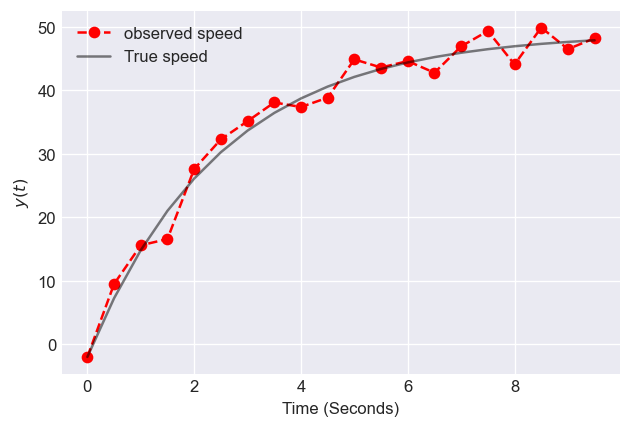

In [23]:
# For reproducibility
np.random.seed(20394)

def freefall(y, t, p):
    return 2.0 * p[1] - p[0] * y[0]

# Times for observation
times = np.arange(0, 10, 0.5)
gamma, g, y0, sigma = 0.4, 9.8, -2, 2
y = odeint(freefall, t=times, y0=y0, args=tuple([[gamma, g]]))
yobs = np.random.normal(y, 2)

fig, ax = plt.subplots(dpi=120)
plt.plot(times, yobs, label="observed speed", linestyle="dashed", marker="o", color="red")
plt.plot(times, y, label="True speed", color="k", alpha=0.5)
plt.legend()
plt.xlabel("Time (Seconds)")
plt.ylabel(r"$y(t)$")

With the equation defined, and observations obtained, the next step is to to set up the parameters for the Bayesian MCMC. We start with the priors for the two unknown parameters, the noise variance $\sigma,$ and the coefficient of air resistance, $\gamma.$ We propose the following priors.

- Prior for $\sigma$ is taken as the half-Cauchy law. This is a relatively heavy-tailed law, with positive values and is weakly informative.
- Prior for $\gamma$ is a log-normal law. This is a common choice to ensure positivity, while maintaining an underlying Gaussian distribution.

Now we can run the MCMC using the `sample` command and recover the results in the `data` variable.

In [24]:
ode_model = DifferentialEquation(func=freefall, times=times, n_states=1, n_theta=2, t0=0)

with pm.Model() as model:
    # Specify prior distributions for model parameters
    sigma = pm.HalfCauchy("sigma", 1)
    gamma = pm.Lognormal("gamma", 0, 1)

    # If we know one of the parameter values, we can simply pass the value.
    ode_solution = ode_model(y0=[0], theta=[gamma, 9.8])
    # The ode_solution has a shape of (n_times, n_states)

    Y = pm.Normal("Y", mu=ode_solution, sigma=sigma, observed=yobs)

    prior = pm.sample_prior_predictive()
    trace = pm.sample(2000, tune=1000, cores=1,return_inferencedata=False)
    posterior_predictive = pm.sample_posterior_predictive(trace)

    data = az.from_pymc3(trace=trace, prior=prior, posterior_predictive=posterior_predictive)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [gamma, sigma]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 231 seconds.


The number of samples and the burn-in require tuning, in general, though default values will usually work reasonably well.

We plot the resulting posteriors for $\sigma$ and $\gamma.$

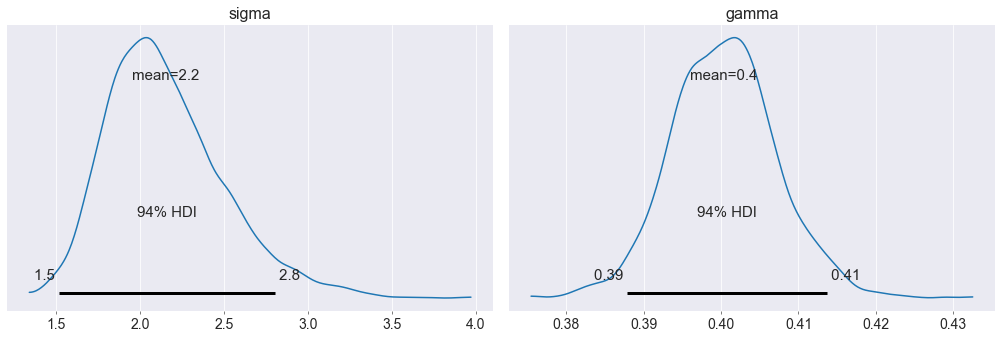

In [12]:
az.plot_posterior(data);
plt.savefig('BayesODEMCMC-post.png',dpi=300)

Suppose that we want now to add $g$ to the parameters to be estimated. It suffices to define a prior and relaunch the MCMC sampling. Computation times are now longer, of course.

In [25]:
with pm.Model() as model2:
    sigma = pm.HalfCauchy("sigma", 1)
    gamma = pm.Lognormal("gamma", 0, 1)
    # A prior on the acceleration due to gravity
    g = pm.Lognormal("g", pm.math.log(10), 2)

    # Notice now I have passed g to the odeparams argument
    ode_solution = ode_model(y0=[0], theta=[gamma, g])

    Y = pm.Normal("Y", mu=ode_solution, sigma=sigma, observed=yobs)

    prior = pm.sample_prior_predictive()
    trace = pm.sample(2000, tune=1000, target_accept=0.9,  cores=1,return_inferencedata=False)
    posterior_predictive = pm.sample_posterior_predictive(trace)

    data = az.from_pymc3(trace=trace, prior=prior, posterior_predictive=posterior_predictive)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [g, gamma, sigma]


/opt/anaconda3/envs/my-pymc3/lib/python3.9/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Illegal input detected (internal error). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 924 seconds.


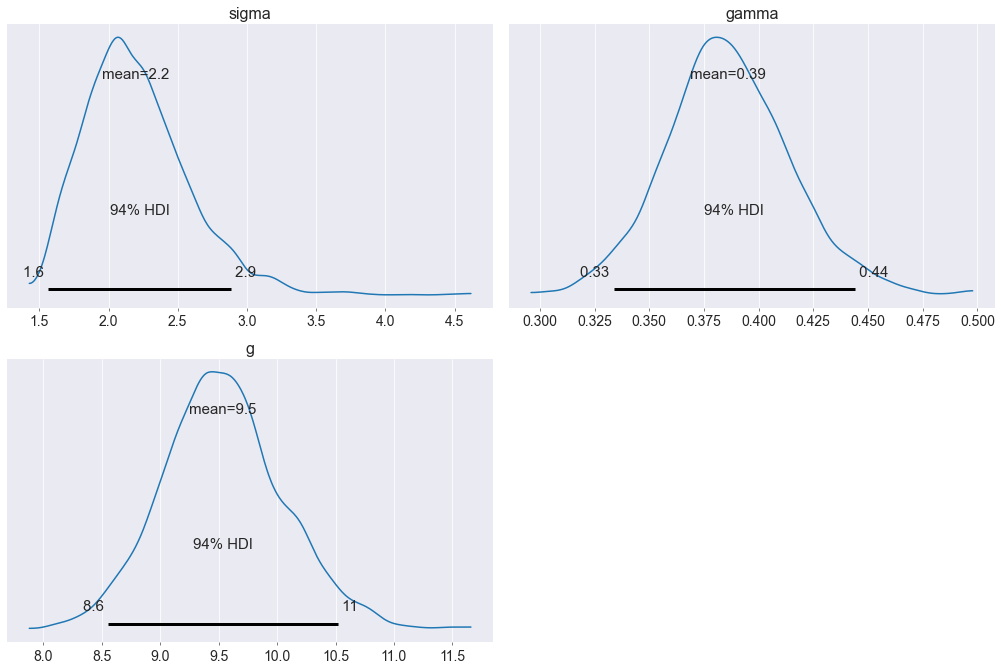

In [26]:
az.plot_posterior(data,grid=(2,2));
plt.savefig('BayesODEMCMC-post3.png',dpi=600)

It is also possible to do inference on the initial condition, but CPU times are very long...

### SIR Model

As a second case, we consider the nonlinear system for modeling the evolution of an infectious disease. This is known as a compartment model, and the three variables are $S,$ the number of susceptibles, $I,$ the number of infectious, and $R,$ the number of recovered individuals.

$$\dfrac{dS}{dt} = - \beta SI \quad S(0) = S_0$$ 
$$\dfrac{dI}{dt} = \beta SI - \lambda I \quad I(0) = I_0$$
$$\dfrac{dR}{dt} = \lambda I \quad R(0) = R_0$$

This model has been widely-used for modeling COVID and with it, one can estimate the famous $R_0,$ the rate of reproduction, 
$$ R_0 = \frac{\beta }{\gamma} S_0.$$

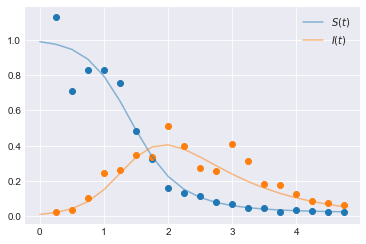

In [15]:
def SIR(y, t, p):
    ds = -p[0] * y[0] * y[1]
    di = p[0] * y[0] * y[1] - p[1] * y[1]
    return [ds, di]


times = np.arange(0, 5, 0.25)

beta, gamma = 4, 1.0
# Create true curves
y = odeint(SIR, t=times, y0=[0.99, 0.01], args=((beta, gamma),), rtol=1e-8)
# Observational model.  Lognormal likelihood isn't appropriate, but we'll do it anyway
yobs = np.random.lognormal(mean=np.log(y[1::]), sigma=[0.2, 0.3])

plt.plot(times[1::], yobs, marker="o", linestyle="none")
plt.plot(times, y[:, 0], color="C0", alpha=0.5, label=f"$S(t)$")
plt.plot(times, y[:, 1], color="C1", alpha=0.5, label=f"$I(t)$")
plt.legend()

In [16]:
sir_model = DifferentialEquation(
    func=SIR,
    times=np.arange(0.25, 5, 0.25),
    n_states=2,
    n_theta=2,
    t0=0,
)

with pm.Model() as model4:
    sigma = pm.HalfCauchy("sigma", 1, shape=2)

    # R0 is bounded below by 1 because we see an epidemic has occured
    R0 = pm.Bound(pm.Normal, lower=1)("R0", 2, 3)
    lam = pm.Lognormal("lambda", pm.math.log(2), 2)
    beta = pm.Deterministic("beta", lam * R0)

    sir_curves = sir_model(y0=[0.99, 0.01], theta=[beta, lam])

    Y = pm.Lognormal("Y", mu=pm.math.log(sir_curves), sigma=sigma, observed=yobs)

    trace = pm.sample(2000, tune=1000, target_accept=0.9, cores=1, return_inferencedata=False)
    data = az.from_pymc3(trace=trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [lambda, R0, sigma]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 2126 seconds.


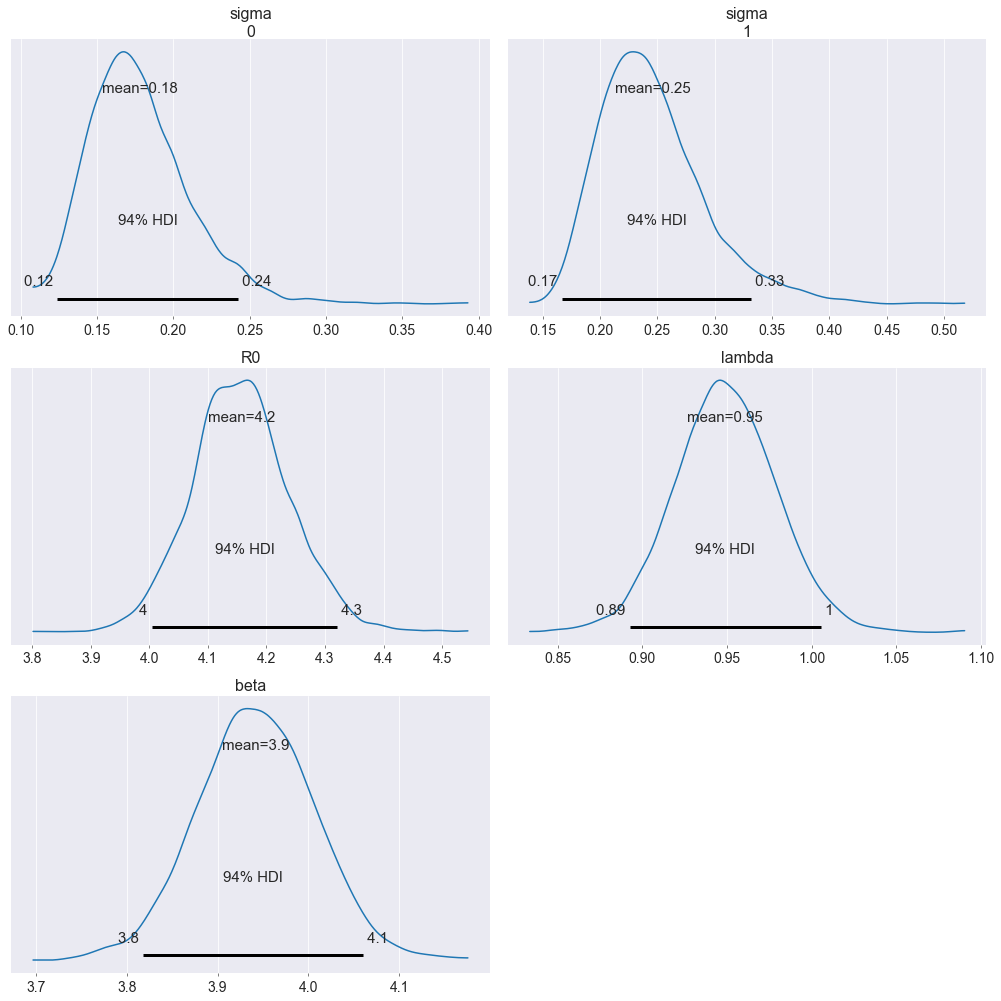

In [18]:
az.plot_posterior(data, round_to=2,grid=(3,2))#, credible_interval=0.95);